In [ ]:
!pip install Box2D
!pip install gym
!apt-get install -y xvfb python-opengl
!pip install pyvirtualdisplay

     |████████████████████████████████| 1.3 MB 17.5 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 40 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,687 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 1,280 kB in 0s (9,092 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_am

In [ ]:
from google.colab import drive
from time import time

drive_path = '/content/drive'

drive.mount(drive_path, force_remount=True)

# /content/drive/MyDrive/Colab Notebooks/lunarlander_dqn : this output directory should exist in the Google Drive
output_dir = drive_path + '/MyDrive/Colab Notebooks/lunarlander_dqn'
output_dir = f'{output_dir}/{str(time())}/'
print(output_dir)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/lunarlander_dqn/1650979185.1390224/


In [ ]:
import random
from collections import deque, defaultdict
import numpy as np
import tensorflow as tf
from tensorflow import keras
import json

class DQN:
    def __init__(
        self,
        input_dim,
        num_actions,
        epsilon_start=1, # initial epsilon
        epsilon_min=0.01, # min epsilon
        epsilon_decay=0.995, # value with with epsilon decays over time
        discount=0.99, 
        experience_buffer_size=500000, # experience replay buffer size
        batch_size=64, # number of experiences sampled from the experience buffer for training
        max_steps_per_episode=5000,
    ):
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model(input_dim, num_actions)
        print(self.model.summary())
        self.experience_buffer = deque(maxlen=experience_buffer_size)
        self.discount = discount
        self.max_steps_per_episode = max_steps_per_episode
        self.batch_size = batch_size
        self.input_dim = input_dim

    def build_model(self, input_dim, num_actions):
        """
        Creates the action-value network

        :param input_dim: dimension of the input layer 
        :param num_actions: number of actions, used for the number of neurons in the output layer  
        :return: tensorflow network model
        """
        model = keras.Sequential(
            [
                keras.layers.Dense(512, input_dim=input_dim, activation='relu', name='layer1'),
                keras.layers.Dense(256, activation='relu', name='layer2'),
                keras.layers.Dense(num_actions, activation='linear', name='layer4'),
            ]
        )
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.MeanSquaredError(),
            # metrics=['accuracy'],
        )
        return model

    def choose_action(self, state, actions):
        """
        Chooses an action using e-greedy policy

        :param state: current state
        :param actions: all possible actions
        :return: action to take
        """
        if np.random.uniform() < self.epsilon:
            return actions.sample()
        action_values = self.model.predict(state)
        return np.argmax(action_values[0])

    # Trains the network/model
    def train(self, env, episodes=1000):
        # print('episodes', episodes)
        episode_rewards_dict = defaultdict(int)
        for episode in range(0, episodes):
            # print('episode', episode)
            state = env.reset()  # Initialise initial state of the environment
            state = np.reshape(state, [1, self.input_dim])
            done = False
            time_step = 0
            episode_reward = 0
            # Run loop until environment reaches terminal state or exhausted max. number of steps
            while not done and time_step < self.max_steps_per_episode:
                time_step += 1

                action = self.choose_action(state, env.action_space)
                next_state, reward, done, info = env.step(action)
                episode_reward += reward
                
                next_state = np.reshape(next_state, [1, self.input_dim])
                # append this experience to the experience buffer
                self.experience_buffer.append((state, action, reward, next_state, done))
                
                # We only do training every 5 steps 
                if time_step % 5 == 0:
                    self.learn_from_experiences()  # train on mini-batch of experiences
                
                state = next_state

            episode_rewards_dict[episode] = episode_reward
            reward_mean = self.get_rewards_mean(episode_rewards_dict)
            
            print(
                episode,
                '{:.6f}'.format(episode_reward),
                '{:.6f}'.format(reward_mean),
                '{:.6f}'.format(self.epsilon),
                time_step,
            )
            
            # save weights
            self.model.save_weights(f'{output_dir}/weights.h5')
            json_object = json.dumps(episode_rewards_dict, indent = 4)
            # Writing to rewards.json
            with open(f'{output_dir}/rewards.json', 'w') as outfile:
                outfile.write(json_object)
            # We stop training when average of last 100 rewards goes above 200. 
            if reward_mean > 200:
                print('Training Complete')
                break
            
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    # calculates the mean of last 100 rewards
    def get_rewards_mean(self, episode_rewards_dict):
        return np.mean(list(episode_rewards_dict.values())[-100:])

    # Trains the model on mini-batches of size batch_size
    # If batch_size is not provided, it uses self.batch_size
    def learn_from_experiences(self, batch_size=None):
        batch_size = batch_size or self.batch_size
        if len(self.experience_buffer) < batch_size:
            return

        s_batch, a_batch, r_batch, next_s_batch, d_batch = self.sample_batch(batch_size)

        targets = r_batch + self.discount * (np.amax(self.model.predict_on_batch(next_s_batch), axis=1)) * (1 - d_batch)
        target_vec = self.model.predict_on_batch(s_batch)
        indexes = np.array([i for i in range(batch_size)])
        target_vec[[indexes], [a_batch]] = targets
        self.model.fit(s_batch, target_vec, epochs=1, verbose=0)

    # Generates a mini-batch of size batch_size from the experience buffer
    def sample_batch(self, batch_size):
        # get a batch from experience buffer
        batch = random.sample(self.experience_buffer, batch_size)
        s_batch = np.array([i[0] for i in batch])
        a_batch = np.array([i[1] for i in batch])
        r_batch = np.array([i[2] for i in batch])
        next_s_batch = np.array([i[3] for i in batch])
        d_batch = np.array([i[4] for i in batch])
        s_batch = np.squeeze(np.squeeze(s_batch))
        next_s_batch = np.squeeze(next_s_batch)
        return s_batch, a_batch, r_batch, next_s_batch, d_batch


In [ ]:
# This code is required to generate the episode videos
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
import gym
from gym.wrappers import Monitor

# Creates LunarLander environment using OpenAI Gym
env = gym.make('LunarLander-v2')
# For recording videos
env = Monitor(env, f'{output_dir}/videos/', video_callable=lambda episode_id: True, force=True)

In [ ]:
# This code generates step frames for an episode which can be used to display an episode in the notebook. 
def get_one_episode_frames(model):
    frames = []
    state = env.reset()
    
    for t in range(1000):
        state = np.reshape(state, [1, env.observation_space.shape[0]])
        action_values = model.predict(state)
        action = np.argmax(action_values[0])
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        state, reward, done, info = env.step(action)
        if done:
            frame = env.render(mode='rgb_array')
            frames.append(frame)
            break
    
    return np.array(frames)


In [ ]:
# Create DQN object
dqn = DQN(env.observation_space.shape[0], env.action_space.n)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 512)               4608      
                                                                 
 layer2 (Dense)              (None, 256)               131328    
                                                                 
 layer4 (Dense)              (None, 4)                 1028      
                                                                 
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation
from IPython.display import HTML

In [ ]:
# Before training frames
before_frames = get_one_episode_frames(dqn.model)

In [ ]:
# Training the DQN agent
dqn.train(env)

0 -87.626408 -87.626408 1.000000 67
1 -86.052750 -86.839579 0.995000 71
2 -138.546585 -104.075248 0.990025 92
3 -238.701052 -137.731699 0.985075 108
4 -334.225069 -177.030373 0.980150 113
5 -78.573847 -160.620952 0.975249 108
6 -249.918365 -173.377725 0.970373 142
7 -134.330893 -168.496871 0.965521 67
8 -254.948440 -178.102601 0.960693 99
9 -302.600578 -190.552399 0.955890 84
10 -442.530419 -213.459491 0.951110 132
11 -91.891507 -203.328826 0.946355 66
12 -195.838937 -202.752681 0.941623 113
13 -82.154574 -194.138530 0.936915 61
14 -79.114837 -186.470284 0.932230 85
15 -160.397650 -184.840744 0.927569 115
16 -167.287728 -183.808214 0.922931 138
17 -104.298914 -179.391031 0.918316 83
18 -197.453954 -180.341711 0.913725 112
19 -70.301894 -174.839720 0.909156 108
20 -161.427405 -174.201038 0.904610 116
21 -123.023675 -171.874795 0.900087 87
22 -136.366140 -170.330940 0.895587 100
23 -185.549266 -170.965037 0.891109 106
24 -59.445028 -166.504237 0.886654 75
25 -79.993356 -163.176895 0.8822

In [ ]:
# Plot episode vs reward
rewards = pd.read_json(f'{output_dir}/rewards.json', orient='index')
rewards.rename(columns={0: 'Reward'}, inplace=True)
rewards

,Reward
0,-87.626408
1,-86.052750
2,-138.546585
3,-238.701052
4,-334.225069
...,...
645,236.385252
646,222.925312
647,253.948275
648,257.131171


In [ ]:
# Calculating moving average of last 100 episodes
rewards['Moving average'] = rewards.rolling(window=100, min_periods=0)['Reward'].mean()
rewards

,Reward,Moving average
0,-87.626408,-87.626408
1,-86.052750,-86.839579
2,-138.546585,-104.075248
3,-238.701052,-137.731699
4,-334.225069,-177.030373
...,...,...
645,236.385252,193.112233
646,222.925312,197.190832
647,253.948275,199.017753
648,257.131171,199.298763


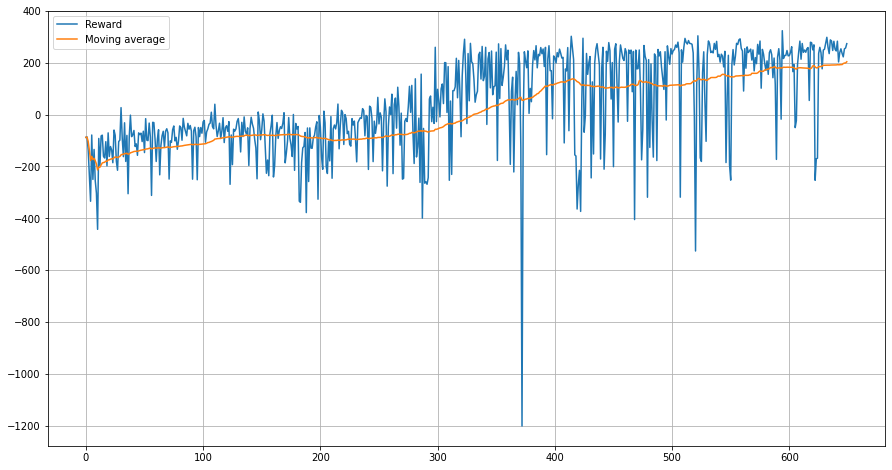

In [ ]:
# Plotting
rewards.plot.line(figsize=(15, 8), grid=True)
plt.show()

In [ ]:
# Used for displaying frames in notebook
def display_frames(frames):
    fig = plt.figure()
    im = plt.imshow(frames[0,:,:,:])
    plt.close()

    def init():
        im.set_data(frames[0,:,:,:])

    def animate(i):
        im.set_data(frames[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames.shape[0], interval=50)
    return HTML(anim.to_html5_video())

In [ ]:
print('Before training')
display_frames(before_frames)

Before training


In [ ]:
# Load saved weights
# weights_path = f'{output_dir}/weights.h5'
# dqn.model.load_weights(weights_path)

In [ ]:
after_training = get_one_episode_frames(dqn.model)
print('After training')
display_frames(after_training)

After training
